In [1]:
import os
import numpy as np
from sklearn.manifold import TSNE

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
import matplotlib.pyplot as plt

import cebra.datasets
from cebra import CEBRA
import cebra
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


### Load and Visualize Data

In [2]:
output_dir = 'data' 
manifest_path = os.path.join(output_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
nat_movie = cache.get_natural_movie_template(1)


In [3]:
cortex = 'VISp'
seed=333
num_neurons = 800
np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')
np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')

In [4]:
np_train_frame_embed = np_train.index.reshape(-1, 4, 768)[:, 0]
np_test_frame_embed = np_test.index.reshape(-1, 4, 768)[:, 0]

In [5]:
first_presentation = np_train.neural[:3600]
reshaped_presentation = first_presentation.reshape(900, 4, -1)
first_p_group = reshaped_presentation.sum(axis=1)

In [6]:
dino_tsne = TSNE(n_components = 2)
dino_tsne_viz = dino_tsne.fit_transform(first_p_group)

/Users/JosephYu/opt/anaconda3/envs/nbd_env/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


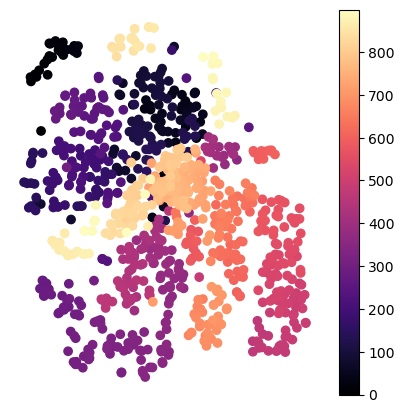

In [7]:
fig = plt.figure(figsize = (5,5))
scatter = plt.scatter(dino_tsne_viz[:,0], dino_tsne_viz[:,1], cmap = 'magma', c = np.arange(900))
plt.axis('off')
plt.colorbar(scatter)
# plt.savefig('../images/tsne_neuropixels.png')
plt.show()

In [8]:
pca = PCA(n_components = 3)
pca_viz = pca.fit_transform(first_p_group)

In [9]:
pca = PCA()
pca.fit(first_p_group)

PCA()

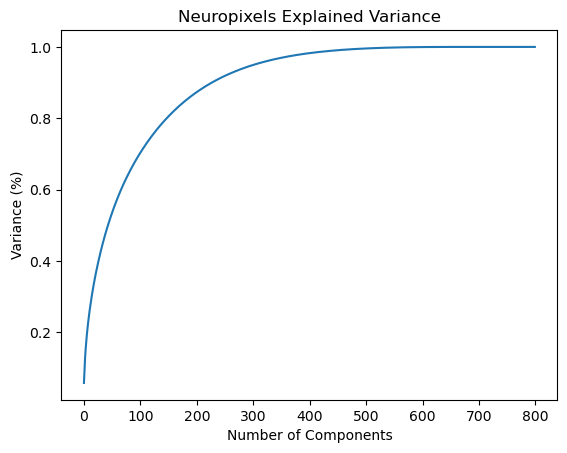

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Neuropixels Explained Variance')

plt.savefig('../images/neuropixels_pca_explained_variance.png')
plt.show()

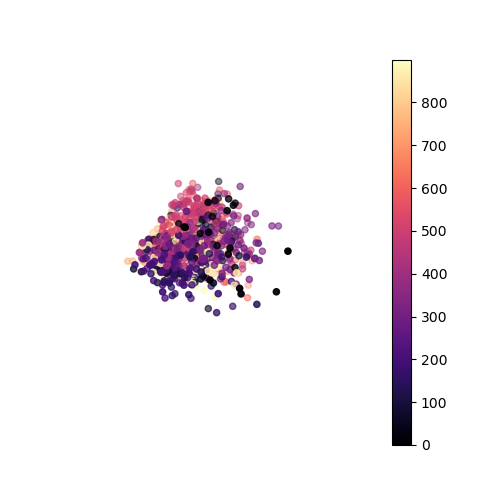

No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c
No such comm: 250b706c93f845e9b64a2f721a63b23c


In [ ]:
%matplotlib widget

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_viz[:,0], pca_viz[:,1], pca_viz[:,2], cmap = 'magma', c = np.arange(900))

plt.axis('off')
plt.colorbar(scatter)

plt.show()

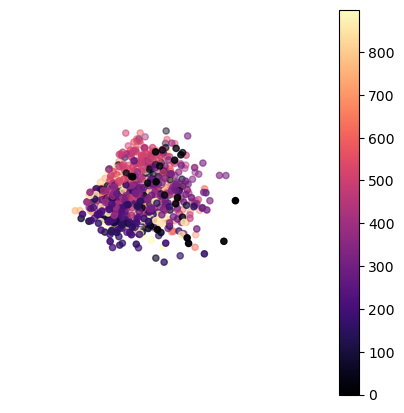

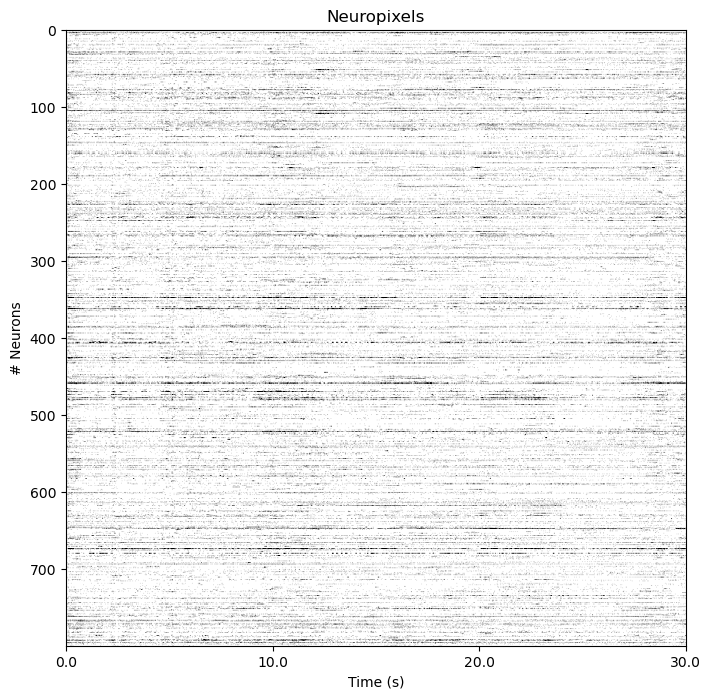

In [12]:
%matplotlib inline

plt.figure(figsize=(8,8))
plt.imshow(np_train.neural.cpu().numpy()[:3600].T, aspect = 'auto', vmax = 1, vmin = 0, cmap ='gray_r')
plt.ylabel('# Neurons')
plt.xlabel('Time (s)')
plt.xticks(np.linspace(0,3600, 4), labels=np.linspace(0,30, 4))
plt.title('Neuropixels')
# plt.savefig('../images/neuropixels.png')
plt.show()

### Set Up Train Test Data

In [13]:
def generate_video_from_np(frame_ids, movie_name):
    import matplotlib.cm as cm
    import matplotlib.animation as animation
    
    arr = nat_movie[frame_ids]

    frames = [] # for storing the generated images
    fig = plt.figure()
    plt.axis('off')

    for i in range(len(arr)):
        frames.append([plt.imshow(arr[i], cmap=cm.Greys_r,animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save(f'{movie_name}.mp4')
    plt.show()

In [14]:
def zscore_2d(arr):
    # Along the time dimension 
    means = np.mean(arr, axis=(0), keepdims=False)
    stds = np.std(arr, axis=(0), keepdims=False)
    
    zscored_arr = (arr - means) / stds
    
    return zscored_arr

In [15]:
np_train_grouped = np_train.neural.numpy().reshape(-1, 4, 800).mean(axis=1)
np_test_grouped = np_test.neural.numpy().reshape(-1, 4, 800).mean(axis=1)
train_frame_index_grouped = np_train.frames_index.reshape(-1, 4)[:, 0]
test_frame_index_grouped = np_test.frames_index.reshape(-1, 4)[:, 0]

In [16]:
neurons_to_remove = set()

for i in range(9):
    current_trial = np_train_grouped[i*900: (i+1)*900, :]
    zero_columns = np.all(current_trial == 0, axis=0)
    zero_column_indices = np.where(zero_columns)[0]
    neurons_to_remove.update(zero_column_indices)

neurons_to_remove = list(neurons_to_remove)

In [17]:
np_train_grouped = np.delete(np_train_grouped, neurons_to_remove, axis=1)
np_test_grouped = np.delete(np_test_grouped, neurons_to_remove, axis=1)

### Neuropixel Lasso Regression

In [338]:
X_train = np_train_grouped
y_train = train_frame_index_grouped
lasso_model = Lasso(alpha=0.08, random_state=2024, fit_intercept=True, max_iter=5000)
lasso_model.fit(X_train, y_train)
train_pred = lasso_model.predict(X_train)

In [339]:
X_test = np_test_grouped
y_test = test_frame_index_grouped

In [340]:
test_pred = lasso_model.predict(X_test)

In [341]:
mse_train = np.mean((train_pred - y_train)**2)
rmse_train = np.sqrt(mse_train)
mae_train = np.mean(np.abs(train_pred - y_train))
r2_train = r2_score(y_train, train_pred)

mse_test = np.mean((test_pred - y_test)**2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(test_pred - y_test))
r2_test = r2_score(y_test, test_pred)

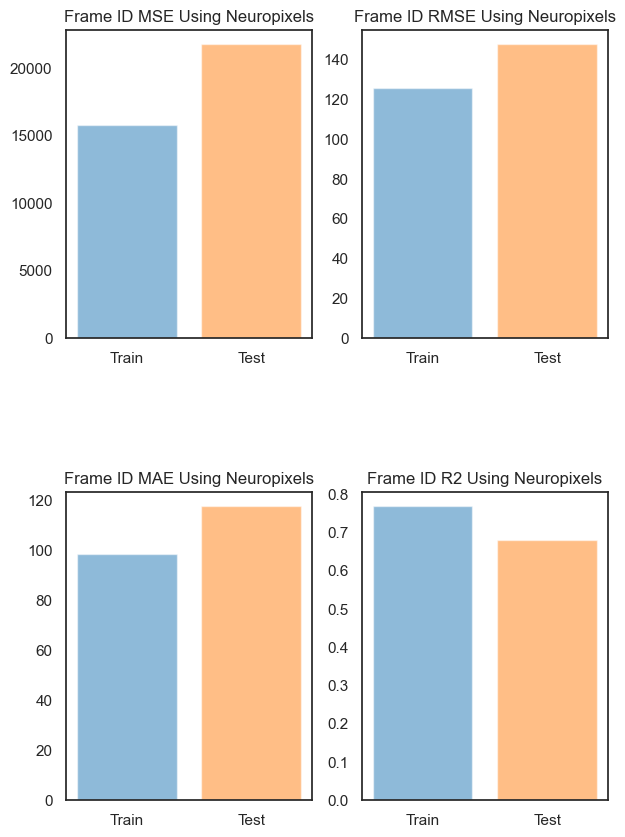

In [342]:
fig, ax = plt.subplots(2, 2, figsize=(7, 10))

sns.set_theme(style='white')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ax[0, 0].bar(range(2), [mse_train, mse_test], color=colors, alpha=0.5)
ax[0, 0].set_xticks(range(2), ["Train", "Test"])
ax[0, 0].set_title('Frame ID MSE Using Neuropixels')

ax[0, 1].bar(range(2), [rmse_train, rmse_test], color=colors, alpha=0.5)
ax[0, 1].set_xticks(range(2), ["Train", "Test"])
ax[0, 1].set_title('Frame ID RMSE Using Neuropixels')

ax[1, 0].bar(range(2), [mae_train, mae_test], color=colors, alpha=0.5)
ax[1, 0].set_xticks(range(2), ["Train", "Test"])
ax[1, 0].set_title('Frame ID MAE Using Neuropixels')

ax[1, 1].bar(range(2), [r2_train, r2_test], color=colors, alpha=0.5)
ax[1, 1].set_xticks(range(2), ["Train", "Test"])
ax[1, 1].set_title('Frame ID R2 Using Neuropixels')

# plt.savefig('../images/frame_id_metrics_lasso_.08.png', bbox_inches='tight', pad_inches=0.1)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [160]:
uniform_scaled_test_pred = (test_pred - np.min(test_pred)) / (np.max(test_pred) - np.min(test_pred)) * 899
predicted_frame_ids = uniform_scaled_test_pred.round().astype(int)

In [163]:
predicted_video = nat_movie[predicted_frame_ids]

### Neuropixel Logistic Regression

In [354]:
X_train = np_train_grouped
y_train = train_frame_index_grouped
X_test = np_test_grouped
y_test = test_frame_index_grouped

In [355]:
X_test_all_unique = []

for i in range(900):
    choices = np.arange(9) * 900 + i
    unused_choices = np.delete(choices, [c in X_test_all_unique for c in choices])
    X_test_all_unique.append(np.random.choice(unused_choices))

X_t = np.delete(X_train, X_test_all_unique, axis=0)
y_t = np.delete(y_train, X_test_all_unique, axis=0)
X_val = X_train[X_test_all_unique]
y_val = y_train[X_test_all_unique]

In [356]:
logistic_model = LogisticRegression(random_state=2024, max_iter=5000, C=0.4)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
y_pred_train = logistic_model.predict(X_train)
accuracy_test = accuracy_score(y_test, y_pred)
mae_test = np.mean(np.abs(y_test - y_pred))
accuracy_train = accuracy_score(y_train, y_pred_train)
mae_train = np.mean(np.abs(y_train - y_pred_train))

In [357]:
mae_test, accuracy_test

(35.41777777777778, 0.04111111111111111)

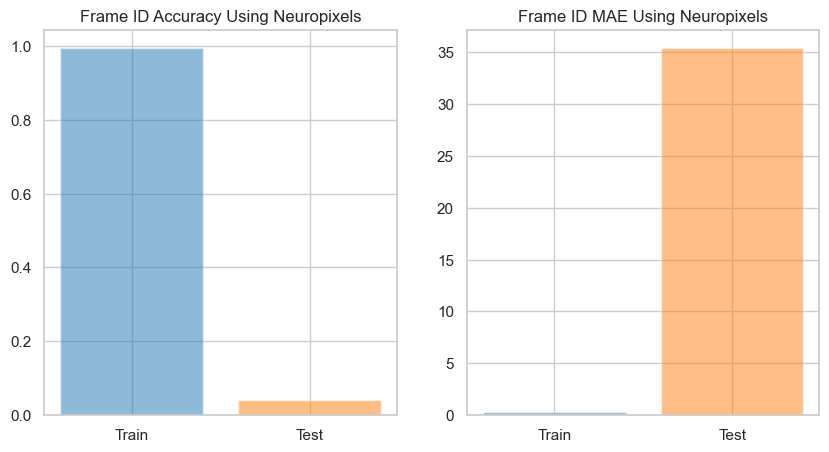

In [333]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ax[0].bar(range(2), [accuracy_train, accuracy_test], color=colors, alpha=0.5)
ax[0].set_xticks(range(2), ["Train", "Test"])
ax[0].set_title('Frame ID Accuracy Using Neuropixels')

ax[1].bar(range(2), [mae_train, mae_test], color=colors, alpha=0.5)
ax[1].set_xticks(range(2), ["Train", "Test"])
ax[1].set_title('Frame ID MAE Using Neuropixels')

# plt.savefig('../images/frame_id_metrics_logistic.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [358]:
y_pred

array([899, 898, 899, 899, 899,   3,   3,   1,   2,   6,   7,   6,  10,
        10,  12,   8,  13, 339,  18,  15,  20,  20,  14,  20,  22,  23,
        22,  20,  50,  33,  36,  21,  30,  23,  36,  50,  30,  56,  99,
       142,  98, 106, 133, 119,  28,  33,  40,  62,  66,  65, 106,  36,
        51,  67,  67, 122,  64, 134,  66,  98, 142, 133, 106, 107, 137,
        65,  53, 134,  50, 134,  65, 139,  68,  71,  71,  73,  73,  73,
        74,  74,  77,  77,  76,  81,  83,  83,  82,  83,  86,  86,  88,
        95,  91,  91,  89,  92,  96,  92,  98, 106, 106,  32,  40, 131,
       131, 124, 109,  96,  95, 115, 109, 113, 538, 101, 114,  67, 122,
       111, 109, 124, 116, 109, 116, 109, 103, 112, 251, 138, 105, 138,
        98, 115, 781, 131, 211, 131, 625, 112, 112, 118, 514, 112, 132,
       137, 138, 143, 144, 145, 142, 416, 147, 149, 147, 152, 150, 150,
       153, 154,  74, 154, 154, 155, 157, 156, 159, 165, 163, 163, 166,
       165, 166, 170, 171, 169, 169, 171, 171, 171, 237, 245, 17

4.3% accuracy and 37.2 average frame error

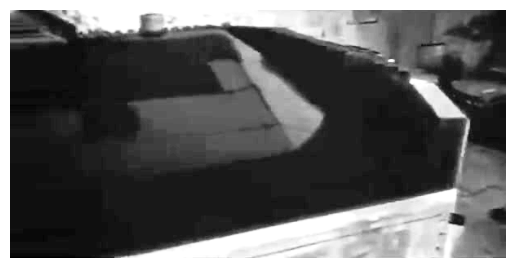

In [ ]:
# generate_video_from_np(y_pred, 'neuropixel_logistic_reg_video')

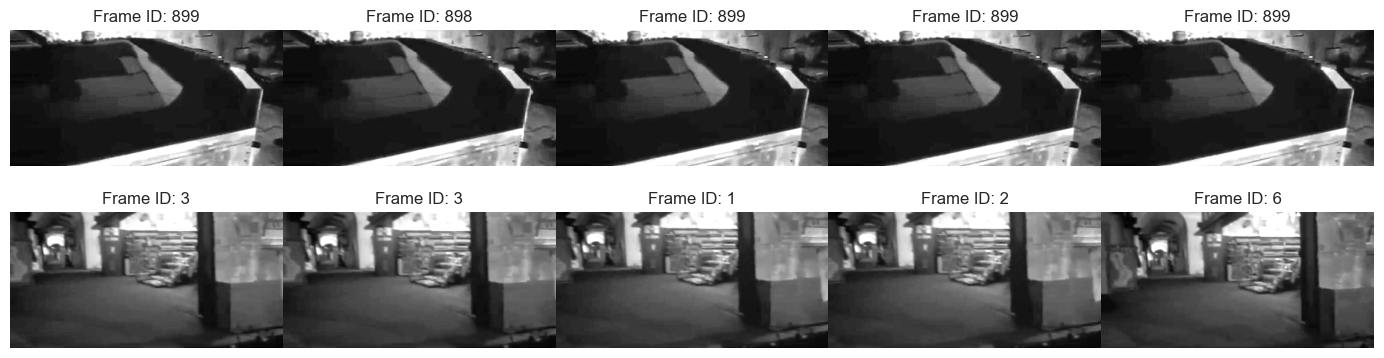

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(14, 4))
ax_flat = ax.flatten()

for i in range(10):
    ax_flat[i].imshow(nat_movie[y_pred[i]], cmap='gray')
    ax_flat[i].set_title(f'Frame ID: {y_pred[i]}')
    ax_flat[i].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('../images/neuropixel_logistic_reg_video.png', bbox_inches='tight', pad_inches=0.1) 
plt.show()

### PCA Lasso Regression

In [343]:
X_train = np_train_grouped
y_train = train_frame_index_grouped
X_test = np_test_grouped
y_test = test_frame_index_grouped

In [344]:
pca = PCA(n_components = 3)
train_pca_viz = pca.fit_transform(X_train)

pca = PCA(n_components = 3)
test_pca_viz = pca.fit_transform(X_test)

In [346]:
X_train = train_pca_viz
y_train = train_frame_index_grouped
X_test = test_pca_viz
y_test = test_frame_index_grouped
lasso_model = Lasso(alpha=0.08, random_state=2024, fit_intercept=True, max_iter=5000)
lasso_model.fit(X_train, y_train)
train_pred = lasso_model.predict(X_train)
test_pred = lasso_model.predict(X_test)

In [347]:
mse_train_pca = np.mean((train_pred - y_train)**2)
rmse_train_pca = np.sqrt(mse_train_pca)
mae_train_pca = np.mean(np.abs(train_pred - y_train))
r2_train_pca = r2_score(y_train, train_pred)

mse_test_pca = np.mean((test_pred - y_test)**2)
rmse_test_pca = np.sqrt(mse_test_pca)
mae_test_pca = np.mean(np.abs(test_pred - y_test))
r2_test_pca = r2_score(y_test, test_pred)

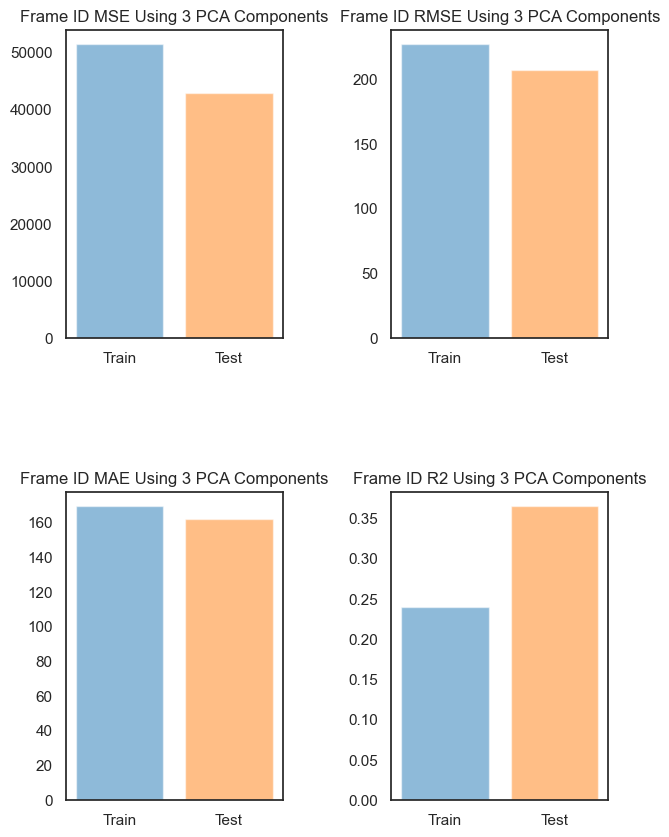

In [348]:
%matplotlib inline

sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(2, 2, figsize=(7, 10))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ax[0, 0].bar(range(2), [mse_train_pca, mse_test_pca], color=colors, alpha=0.5)
ax[0, 0].set_xticks(range(2), ["Train", "Test"])
ax[0, 0].set_title('Frame ID MSE Using 3 PCA Components')

ax[0, 1].bar(range(2), [rmse_train_pca, rmse_test_pca], color=colors, alpha=0.5)
ax[0, 1].set_xticks(range(2), ["Train", "Test"])
ax[0, 1].set_title('Frame ID RMSE Using 3 PCA Components')

ax[1, 0].bar(range(2), [mae_train_pca, mae_test_pca], color=colors, alpha=0.5)
ax[1, 0].set_xticks(range(2), ["Train", "Test"])
ax[1, 0].set_title('Frame ID MAE Using 3 PCA Components')

ax[1, 1].bar(range(2), [r2_train_pca, r2_test_pca], color=colors, alpha=0.5)
ax[1, 1].set_xticks(range(2), ["Train", "Test"])
ax[1, 1].set_title('Frame ID R2 Using 3 PCA Components')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.savefig('../images/frame_id_metrics_lasso_using_pca.08.png', bbox_inches='tight', pad_inches=0.1)

plt.show()

### TSNE Lasso Regression

In [349]:
X_train = np_train_grouped
y_train = train_frame_index_grouped
X_test = np_test_grouped
y_test = test_frame_index_grouped

tsne = TSNE(n_components = 2)
X_train = tsne.fit_transform(X_train)

tsne = TSNE(n_components = 2)
X_test = tsne.fit_transform(X_test)

In [353]:
lasso_model = Lasso(alpha=0.08, random_state=2024, fit_intercept=True, max_iter=5000)
lasso_model.fit(X_train, y_train)
train_pred = lasso_model.predict(X_train)
test_pred = lasso_model.predict(X_test)

In [351]:
mse_train_tsne = np.mean((train_pred - y_train)**2)
rmse_train_tsne = np.sqrt(mse_train_tsne)
mae_train_tsne = np.mean(np.abs(train_pred - y_train))
r2_train_tsne = r2_score(y_train, train_pred)

mse_test_tsne = np.mean((test_pred - y_test)**2)
rmse_test_tsne = np.sqrt(mse_test_tsne)
mae_test_tsne = np.mean(np.abs(test_pred - y_test))
r2_test_tsne = r2_score(y_test, test_pred)

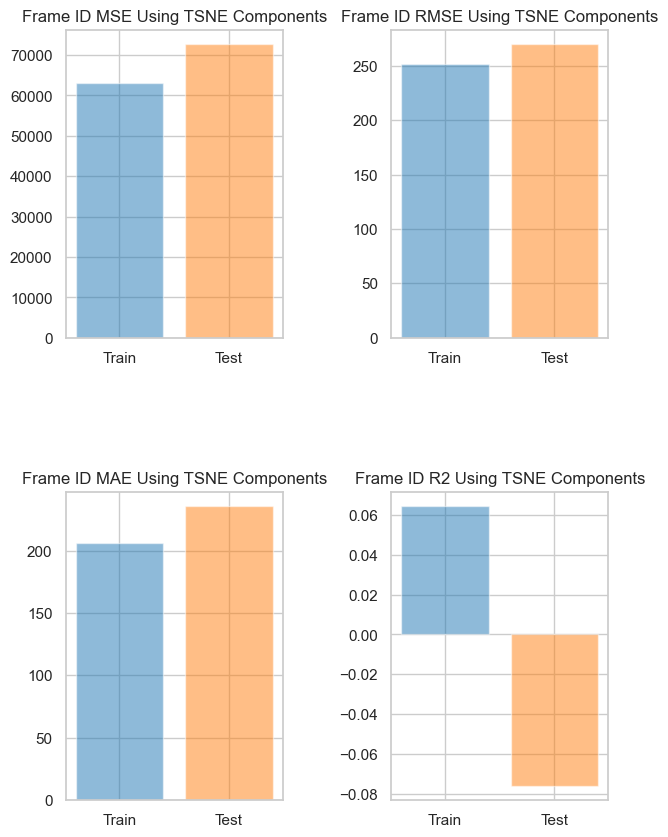

In [354]:
fig, ax = plt.subplots(2, 2, figsize=(7, 10))

sns.set_theme(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ax[0, 0].bar(range(2), [mse_train_tsne, mse_test_tsne], color=colors, alpha=0.5)
ax[0, 0].set_xticks(range(2), ["Train", "Test"])
ax[0, 0].set_title('Frame ID MSE Using TSNE Components')

ax[0, 1].bar(range(2), [rmse_train_tsne, rmse_test_tsne], color=colors, alpha=0.5)
ax[0, 1].set_xticks(range(2), ["Train", "Test"])
ax[0, 1].set_title('Frame ID RMSE Using TSNE Components')

ax[1, 0].bar(range(2), [mae_train_tsne, mae_test_tsne], color=colors, alpha=0.5)
ax[1, 0].set_xticks(range(2), ["Train", "Test"])
ax[1, 0].set_title('Frame ID MAE Using TSNE Components')

ax[1, 1].bar(range(2), [r2_train_tsne, r2_test_tsne], color=colors, alpha=0.5)
ax[1, 1].set_xticks(range(2), ["Train", "Test"])
ax[1, 1].set_title('Frame ID R2 Using TSNE Components')

plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.savefig('../images/frame_id_metrics_lasso_using_tsne.08.png', bbox_inches='tight', pad_inches=0.1)

plt.show()


### PCA kNN Classifier

In [117]:
X_train = np.concatenate([np_train_grouped, np_test_grouped], axis=0)
y_train = np.concatenate([train_frame_index_grouped, test_frame_index_grouped], axis=0)

In [120]:
components = np.arange(.1, 1., .1)
best_accuracies = []
best_mae = []
best_ks = []

for component in components:
    pca = PCA(n_components = component)
    train_pca_viz = pca.fit_transform(X_train)

    X_t, X_val, y_t, y_val = train_test_split(train_pca_viz, y_train, test_size=0.2, random_state=2024)
    current_accuracy = 0
    best_k = 0
    current_mae = float('inf')
    for k in range(1, 10):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_t, y_t)

        y_pred = knn.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        mae = np.mean(np.abs(y_val - y_pred))
        if accuracy > current_accuracy:
            current_accuracy = accuracy
        
        if mae < current_mae:
            current_mae = mae
            best_k = k
        
    best_ks.append(best_k); best_accuracies.append(current_accuracy); best_mae.append(current_mae)




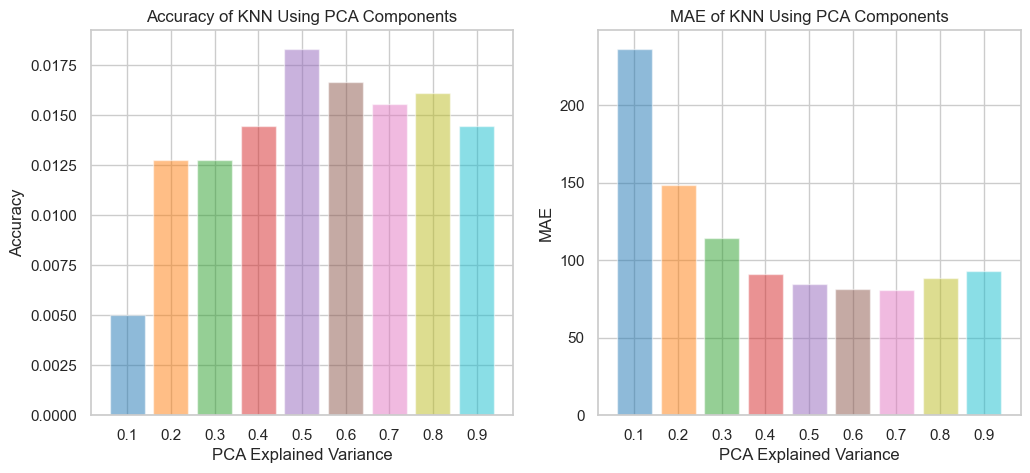

In [ ]:
sns.set_theme(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(x = range(9), height=best_accuracies, color=colors, alpha=0.5)
ax[0].set_xticks(range(9), [f'{round(i, 1)}' for i in components])
ax[0].set_xlabel('PCA Explained Variance')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy of KNN Using PCA Components')

ax[1].bar(x = range(9), height=best_mae, color=colors, alpha=0.5)
ax[1].set_xticks(range(9), [f'{round(i, 1)}' for i in components])
ax[1].set_xlabel('PCA Explained Variance')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE of KNN Using PCA Components')
# plt.savefig('../images/knn_pca_accuracy_mae.png', bbox_inches='tight')
plt.show()

In [98]:
X_test_all_unique = []

for i in range(900):
    choice = np.random.choice(np.arange(9))
    X_test_all_unique.append(choice*900 + i)


In [99]:
X_train_subset = np.delete(X_train, X_test_all_unique, axis=0)
y_train_subset = np.delete(y_train, X_test_all_unique, axis=0)
X_test_subset = X_train[X_test_all_unique]
y_test_subset = y_train[X_test_all_unique]

In [100]:
pca = PCA(n_components = .9)
train_pca_viz = pca.fit_transform(X_train_subset)
test_pca_viz = pca.transform(X_test_subset)

In [102]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(train_pca_viz, y_train_subset)

y_pred = knn.predict(test_pca_viz)

In [103]:
mae = np.mean(np.abs(y_test_subset - y_pred))
accuracy = accuracy_score(y_test_subset, y_pred)
mae, accuracy

(83.49111111111111, 0.012222222222222223)

1.6% accuracy 89 average frame error

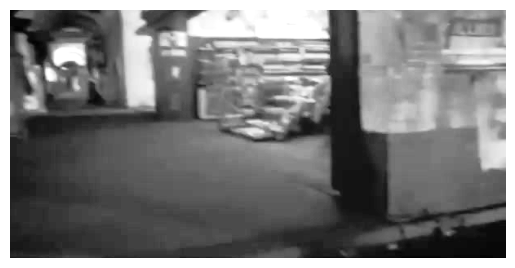

In [93]:
generate_video_from_np(y_pred, 'knn_video')

### PCA Logistic Regression

In [371]:
X_train = np.concatenate([np_train_grouped, np_test_grouped], axis=0)
y_train = np.concatenate([train_frame_index_grouped, test_frame_index_grouped], axis=0)

In [300]:
components = list(np.arange(.1, 1., .1))
components.append(X_train.shape[1])

In [138]:
best_mae = []
best_accuracies = []
dimensions = []
for component in components:
    pca = PCA(n_components = component)
    train_pca_viz = pca.fit_transform(X_train)
    if component < 1:
        dimensions.append(train_pca_viz.shape[1])
    else:
        dimensions.append(component)
    X_t, X_val, y_t, y_val = train_test_split(train_pca_viz, y_train, test_size=0.2, random_state=2024)

    logistic_model = LogisticRegression(random_state=2024, max_iter=5000)
    logistic_model.fit(X_t, y_t)

    y_pred = logistic_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    mae = np.mean(np.abs(y_val - y_pred))

    best_accuracies.append(accuracy)
    best_mae.append(mae)

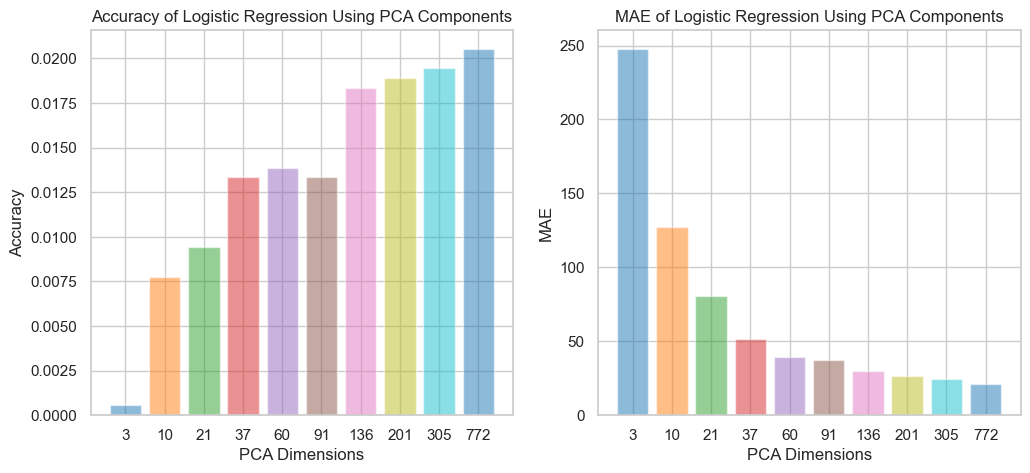

In [ ]:
sns.set_theme(style='whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(x = range(len(components)), height=best_accuracies, color=colors, alpha=0.5)
ax[0].set_xticks(range(len(components)), dimensions)
ax[0].set_xlabel('PCA Dimensions')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy of Logistic Regression Using PCA Components')


ax[1].bar(x = range(len(components)), height=best_mae, color=colors, alpha=0.5)
ax[1].set_xticks(range(len(components)), dimensions)
ax[1].set_xlabel('PCA Dimensions')
ax[1].set_ylabel('MAE')
ax[1].set_title('MAE of Logistic Regression Using PCA Components')

# plt.savefig('../images/logistic_pca_accuracy_mae.png', bbox_inches='tight')
plt.show()

In [415]:
X_test_all_unique = []
# np.random.seed(5)
for i in range(900):
    choice = np.random.choice(np.arange(9))
    X_test_all_unique.append(choice*900 + i)

In [416]:
X_train_subset = np.delete(X_train, X_test_all_unique, axis=0)
y_train_subset = np.delete(y_train, X_test_all_unique, axis=0)
X_test_subset = X_train[X_test_all_unique]
y_test_subset = y_train[X_test_all_unique]

In [417]:
pca = PCA(n_components = .9)
train_pca_viz = pca.fit_transform(X_train_subset)
test_pca_viz = pca.transform(X_test_subset)

In [418]:
logistic_model = LogisticRegression(random_state=2024, max_iter=5000, C=.4)
logistic_model.fit(train_pca_viz, y_train_subset)

y_pred = logistic_model.predict(test_pca_viz)
y_pred_train = logistic_model.predict(train_pca_viz)

mae = np.mean(np.abs(y_test_subset - y_pred))
accuracy = accuracy_score(y_test_subset, y_pred)

mae_train = np.mean(np.abs(y_train_subset - y_pred_train))
accuracy_train = accuracy_score(y_train_subset, y_pred_train)


In [419]:
mae, accuracy

(21.756666666666668, 0.02)

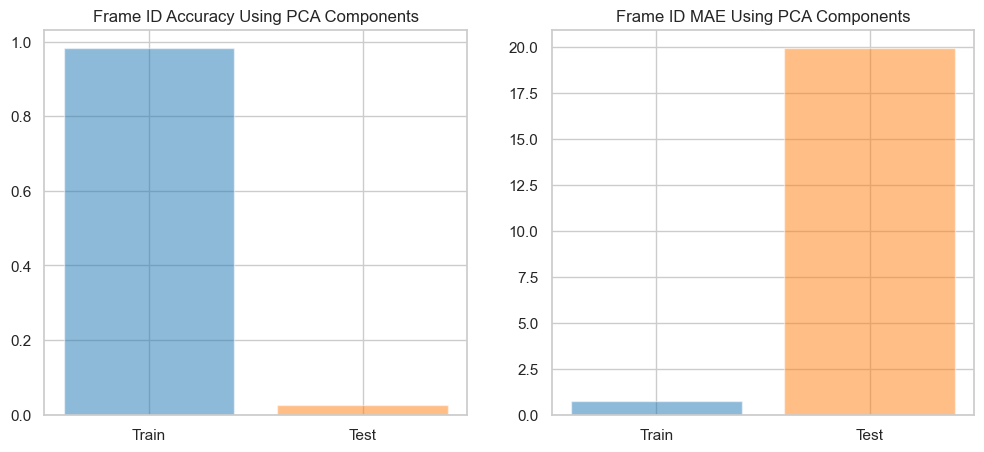

In [ ]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
ax[0].bar(range(2), [accuracy_train, accuracy], color=colors, alpha=0.5)
ax[0].set_xticks(range(2), ["Train", "Test"])
ax[0].set_title('Frame ID Accuracy Using PCA Components')

ax[1].bar(range(2), [mae_train, mae], color=colors, alpha=0.5)
ax[1].set_xticks(range(2), ["Train", "Test"])
ax[1].set_title('Frame ID MAE Using PCA Components')

# plt.savefig('../images/frame_id_metrics_logistic_C_.4_pca.png', bbox_inches='tight', pad_inches=0.1)
plt.show()



In [420]:
y_pred

array([  0,   0,   0,   8,   5,   0,   7,   9,  15,  11,  12,  12,  11,
        12,  11,  20,  15,  15,  20,  15,  21,  50,  21,  22,  21,  22,
        30,  28,  27,  30,  32,  33,  35,  51,  41,  47,  31,  99,  31,
        60, 529,  30, 771,  37,  92,  55,  96,  45,  46,  50,  49,  49,
        28, 526,  62,  50,  43,  61,  61, 108,  33,  63,  31, 102, 101,
        37,  48,  48,  72,  72,  71,  72,  74,  70,  77,  73,  77,  78,
        77,  78,  83,  83,  81,  93,  86,  84,  88,  88,  86,  87,  88,
        93,  90,  89,  94,  58,  95,  99,  94, 103,  99,  61, 109,  96,
       116, 104, 111, 104,  62, 112, 111, 112, 125, 107, 135, 120, 120,
       779, 131, 116,  91, 518, 132, 119,  58, 118, 127, 137, 131, 122,
       122, 107, 456, 125, 135, 124, 764, 107,  72, 141, 225, 139, 139,
       207, 145, 143, 147, 148, 147, 151, 147, 157, 153, 153, 153, 157,
       154, 160, 159, 160, 159, 160, 167, 162, 170, 168, 165, 166, 169,
       170, 171, 173, 169, 172, 171, 176, 174, 178, 184, 184, 18

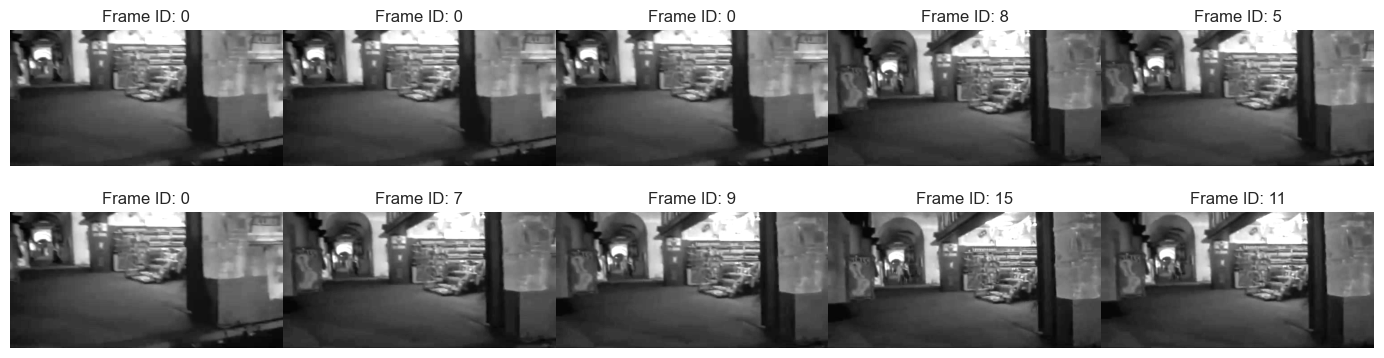

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(14, 4))
ax_flat = ax.flatten()

for i in range(10):
    ax_flat[i].imshow(nat_movie[y_pred[i]], cmap='gray')
    ax_flat[i].set_title(f'Frame ID: {y_pred[i]}')
    ax_flat[i].axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('../images/.9_pca_logistic_reg_video.png', bbox_inches='tight', pad_inches=0.1) 
plt.show()

2.1% accuracy 29.7 average frame error

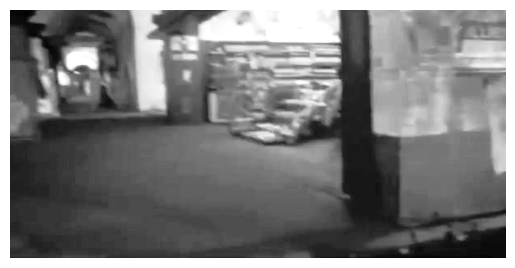

In [ ]:
# generate_video_from_np(y_pred, 'pca_logistic_reg_video')

### VAE Model

In [31]:
import torch
import torch.nn as nn


mse_loss = nn.MSELoss(reduction='mean')
ce_loss = nn.CrossEntropyLoss(reduction='mean')
l1_loss = nn.L1Loss(reduction='mean')

class VAE_Model(nn.Module):
    def __init__(self, x_dim, y_dim, z_dim, vae_model_beta_value):
        super(VAE_Model, self).__init__()
        # Behavioral Decoder Weights
        self.label_dim_n = y_dim

        self.classification_head = None
        self.regression_head = None
        if self.label_dim_n > 0:
            self.classification_head = nn.Sequential(
                nn.Linear(self.label_dim_n, 900, bias=True),
                nn.Dropout(0.2),
            )
            self.regression_head = nn.Linear(self.label_dim_n, 32, bias=True)

        # Encoder Weights
        self.x_dim = x_dim

        encoder_layers, neural_decoder_layers = [], []
        prev_size = x_dim

        hidden_sizes = [x_dim, x_dim, x_dim]
        # hidden_sizes = [x_dim, 350]
        # hidden_sizes = [x_dim, x_dim, x_dim]

        for i, hidden_size in enumerate(hidden_sizes):
            encoder_layers.append(nn.Linear(prev_size, hidden_size))
            encoder_layers.append(nn.LeakyReLU())
            prev_size = hidden_size
        
        decoder_hidden_sizes = [x_dim, x_dim, x_dim]
        # decoder_hidden_sizes = [350, x_dim]
        # decoder_hidden_sizes = [x_dim, x_dim, x_dim]
        
        prev_size = z_dim
        for i, hidden_size in enumerate(decoder_hidden_sizes):
            neural_decoder_layers.append(nn.Linear(prev_size, hidden_size))
            if i != len(decoder_hidden_sizes) - 1:
                neural_decoder_layers.append(nn.LeakyReLU())
            prev_size = hidden_size

        self.encoder = nn.Sequential(*encoder_layers)
        self.neural_decoder = nn.Sequential(*neural_decoder_layers)

        print(f'Encoder: {self.encoder}')
        print(f'Decoder: {self.neural_decoder}')
        
        z_layer_size = x_dim
        if hidden_sizes:
            z_layer_size = hidden_sizes[-1]

        self.z_mean_WT = nn.Linear(z_layer_size, z_dim, bias=True)
        self.z_log_var_WT = nn.Linear(z_layer_size, z_dim, bias=True)

        # Beta Values
        self.beta_kl = vae_model_beta_value

    def encode(self, x):
        _x = self.encoder(x)

        z_mean = self.z_mean_WT(_x)
        
        z_log_var = torch.clamp(self.z_log_var_WT(_x) + 1e-6, min=-10, max=10)
        
        return z_mean, z_log_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x_hat = self.neural_decoder(z)

        y_hat = torch.zeros((z.shape[0], 900))
        y_hat_reg = torch.zeros((z.shape[0], 32))
        if self.label_dim_n > 0:
            y_hat = self.classification_head(z)
            y_hat_reg = self.regression_head(z)

        return x_hat, y_hat, y_hat_reg

    def forward(self, x, phase):
        mu, logvar = self.encode(x)
        if phase == 'Train':
            z = self.reparameterize(mu, logvar)
        else:
            z = mu

        decoded_x, y_hat, y_hat_reg = self.decode(z)

        # check if decoded x contains NaN values
        if torch.isnan(decoded_x).any():
            print('Decoded X contains NaN values', decoded_x)

        return (decoded_x, y_hat, y_hat_reg), z, mu, logvar

    # AE Loss Function
    def vae_loss_func(self, x_hat, y_hat, y_hat_reg, x, y, mu, logvar):
        kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

        kl_loss = self.beta_kl * kl_div.clamp(min=0, max=1e6) 

        mse_x = mse_loss(x_hat, x)

        ce_y = torch.tensor(0.0)

        mse_loss_y = mse_loss(y_hat_reg, y)

        l2_head = torch.tensor(0.0)
        if self.label_dim_n > 0:
            l2_head = 1e-2 * torch.tensor([torch.norm(param, 2) for param in self.classification_head.parameters()]).sum()
        
        mse = mse_x + kl_loss
        if self.label_dim_n > 0:
            mse += mse_loss_y

        return mse, mse_x, ce_y, kl_loss, mse_loss_y

In [19]:

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.astype(np.float32)
        self.labels = labels.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return item, label

In [20]:
def validate_model_r2_rmse(model, x, y):
  with torch.no_grad():
    # Get the Hidden States
    (x_preds, _, y_preds), _, _, _, = model(torch.tensor(x, dtype=torch.float32), phase='test')

    x_preds_flatten = x_preds.reshape(-1, x_preds.shape[-1])

    neural_actual = x
    neural_predicted = x_preds_flatten

    x_mse = torch.mean((neural_predicted - neural_actual) ** 2) 
    x_rmse = torch.sqrt(x_mse)  
    x_r2_score_value = r2_score(np.array(x), np.array(x_preds_flatten))

    # y_accuracy = torch.eq(torch.argmax(y_preds, dim=1), torch.tensor(y)).float().mean()

    y_preds_flatten = y_preds.reshape(-1, y_preds.shape[-1])
    y_accuracy = r2_score(np.array(y), np.array(y_preds_flatten))

    return x_rmse, x_r2_score_value, y_accuracy

In [21]:
def format_loss(loss):
    return f"{loss:,.2f}"

def init_model(X, Y, y_labels, seed, vae_model_beta_value=0.2, hidden_size=10, y_dim=5):

    X_test_all_unique = []

    for _ in range(2):
        for i in range(900):
            choices = np.arange(9) * 900 + i
            unused_choices = np.delete(choices, [c in X_test_all_unique for c in choices])
            X_test_all_unique.append(np.random.choice(unused_choices))
    
    X_train = np.delete(X, X_test_all_unique, axis=0)
    y_train = np.delete(Y, X_test_all_unique, axis=0)
    y_train_labels = np.delete(y_labels, X_test_all_unique, axis=0)
    X_test = X[X_test_all_unique]
    y_test = Y[X_test_all_unique]
    y_test_labels = y_labels[X_test_all_unique]
    print(y_test.shape)

    vae_model = VAE_Model(x_dim=X.shape[-1], y_dim=y_dim, z_dim=hidden_size, vae_model_beta_value=vae_model_beta_value)

    vae_model.apply(weights_init)
    return X_train, X_test, y_train, y_test, y_train_labels, y_test_labels, vae_model

def model_training_and_validating(X, Y, y_labels, seed, vae_model_beta_value=0.2, num_epochs=400, silent=False, concat_train_test=False, hidden_size=10, y_dim = 5):
    
    init_args = (X, Y, y_labels, seed, vae_model_beta_value, hidden_size, y_dim)

    X_train, X_test, y_train, y_test, y_train_labels, y_test_labels, vae_model = init_model(*init_args)

    optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

    x_data = np.concatenate((X_train, X_test), axis=0) if concat_train_test else X_train
    y_data = np.concatenate((y_train, y_test), axis=0) if concat_train_test else y_train

    dataset = CustomDataset(x_data, y_data)
    train_loader = DataLoader(dataset, batch_size=48, shuffle=True)
    loss_keys = ['losses', 'losses_x', 'losses_y', 'losses_c', 'losses_kl', 'losses_reg_y']
    x_train_metrics = ['x_train_rmses', 'x_train_r2_scores', 'y_train_accuracy']
    x_test_metrics = ['x_test_rmses', 'x_test_r2_scores', 'y_test_accuracy']
    losses_dict = {k: [] for k in loss_keys}
    metrics_dict = {k: [] for k in x_train_metrics + x_test_metrics}

    for epoch in range(1, num_epochs + 1):
        vae_model.train()  
        total_mse_loss, total_mse_x_loss, total_mse_y_loss, total_kl_loss, total_reg_loss_y = 0, 0, 0, 0, 0

        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            vae_model.beta_kl = min(vae_model_beta_value, vae_model_beta_value * epoch/num_epochs)

            (x_hat, y_hat, y_hat_reg), _, mu, logvar = vae_model(x, phase='Train')

            loss, loss_x, loss_y, loss_kl, reg_loss_y = vae_model.vae_loss_func(x_hat, y_hat, y_hat_reg, x, y, mu, logvar)

            total_mse_loss += loss.item(); total_mse_x_loss += loss_x.item(); total_kl_loss += loss_kl.item(); total_reg_loss_y += reg_loss_y.item(); total_mse_y_loss += loss_y.item()

            loss.backward()
            optimizer.step()


        losses_dict['losses'].append(total_mse_loss); losses_dict['losses_x'].append(total_mse_x_loss); losses_dict['losses_y'].append(total_mse_y_loss); losses_dict['losses_kl'].append(total_kl_loss); losses_dict['losses_reg_y'].append(total_reg_loss_y)

        x_train_rmse, x_train_r2_score, y_train_accuracy = validate_model_r2_rmse(vae_model, x_data, y_data) if concat_train_test else validate_model_r2_rmse(vae_model, X_train, y_train)
        x_test_rmse, x_test_r2_score, y_test_accuracy = validate_model_r2_rmse(vae_model, X_test, y_test)

        metrics_dict['x_train_rmses'].append(x_train_rmse); metrics_dict['x_train_r2_scores'].append(x_train_r2_score); metrics_dict['y_train_accuracy'].append(y_train_accuracy)
        metrics_dict['x_test_rmses'].append(x_test_rmse); metrics_dict['x_test_r2_scores'].append(x_test_r2_score); metrics_dict['y_test_accuracy'].append(y_test_accuracy)

        if (epoch % 20 == 0 or epoch == 1) and not silent:
            print(f"Epoch number: {epoch}, losses_kl: {format_loss(losses_dict['losses_kl'][-1])}, losses_reg_y: {format_loss(losses_dict['losses_reg_y'][-1])} losses_y: {format_loss(losses_dict['losses_y'][-1])}, y_train_accuracy: {format_loss(y_train_accuracy)}, y_test_accuracy: {format_loss(y_test_accuracy)}, test_r2: {format_loss(x_test_r2_score)}, total_loss: {format_loss(losses_dict['losses'][-1])}")


    return vae_model, losses_dict, metrics_dict, [X_train, X_test, y_train, y_test, y_train_labels, y_test_labels]

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu') 


In [22]:
def set_seed(seed):
    # Set seed for Python's built-in random module
    random.seed(seed)
    
    # Set seed for NumPy
    np.random.seed(seed)
    
    # Set seed for PyTorch (CPU and GPU)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    
    # Ensure reproducibility of CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Disable the auto-tuner that selects the best algorithm for hardware

    # For better reproducibility in PyTorch's random operations
    torch.use_deterministic_algorithms(True)

In [26]:
X_train = np.concatenate([np_train_grouped, np_test_grouped], axis=0)
y_train = np.concatenate([train_frame_index_grouped, test_frame_index_grouped], axis=0)
y_train_dino_embed = np.concatenate([np_train_frame_embed, np_test_frame_embed], axis=0)

In [27]:
X_train = zscore_2d(X_train)

In [436]:
cov_matrix_full = np.cov(X_train, rowvar=False)
total_var = np.trace(cov_matrix_full)

In [437]:
var_np_train = np.var(X_train, axis=0)
top_var_ind = np.argsort(var_np_train)[-393: ]
np_train_grouped_top = X_train[:, top_var_ind]
X_train = zscore_2d(np_train_grouped_top)

In [441]:
top_neuron_cov_matrix = np.cov(np_train_grouped_top, rowvar=False)
total_var_top = np.trace(top_neuron_cov_matrix)
explained_var = total_var_top / total_var

In [442]:
explained_var

0.8891983249456911

In [423]:
y_train_dino_embed.shape

(9000, 768)

In [28]:
pca = PCA(n_components = .9)
y_train_dino_embed_pca = pca.fit_transform(y_train_dino_embed)

In [32]:
seed = 2024
set_seed(int(seed))
print("model results of seed: ", seed)
args = {
    'X': X_train,
    'Y': y_train_dino_embed_pca,
    'y_labels': y_train,
    'seed': seed,
    'vae_model_beta_value': .05,
    'num_epochs': 200,
    'silent': False,
    'concat_train_test': False,
    'hidden_size': 128,
    'y_dim': 0,
}
vae_model, losses_dict, metrics_dict, data_split = model_training_and_validating(**args)


model results of seed:  2024
(1800, 32)
Encoder: Sequential(
  (0): Linear(in_features=772, out_features=772, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=772, out_features=772, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=772, out_features=772, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
)
Decoder: Sequential(
  (0): Linear(in_features=128, out_features=772, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=772, out_features=772, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=772, out_features=772, bias=True)
)
Epoch number: 1, losses_kl: 0.11, losses_reg_y: 2.21 losses_y: 0.00, y_train_accuracy: 0.00, y_test_accuracy: -0.00, test_r2: -0.00, total_loss: 165.29
Epoch number: 20, losses_kl: 1.67, losses_reg_y: 2.21 losses_y: 0.00, y_train_accuracy: 0.00, y_test_accuracy: -0.00, test_r2: 0.24, total_loss: 105.44
Epoch number: 40, losses_kl: 3.12, losses_reg_y: 2.21 losses

KeyboardInterrupt: 

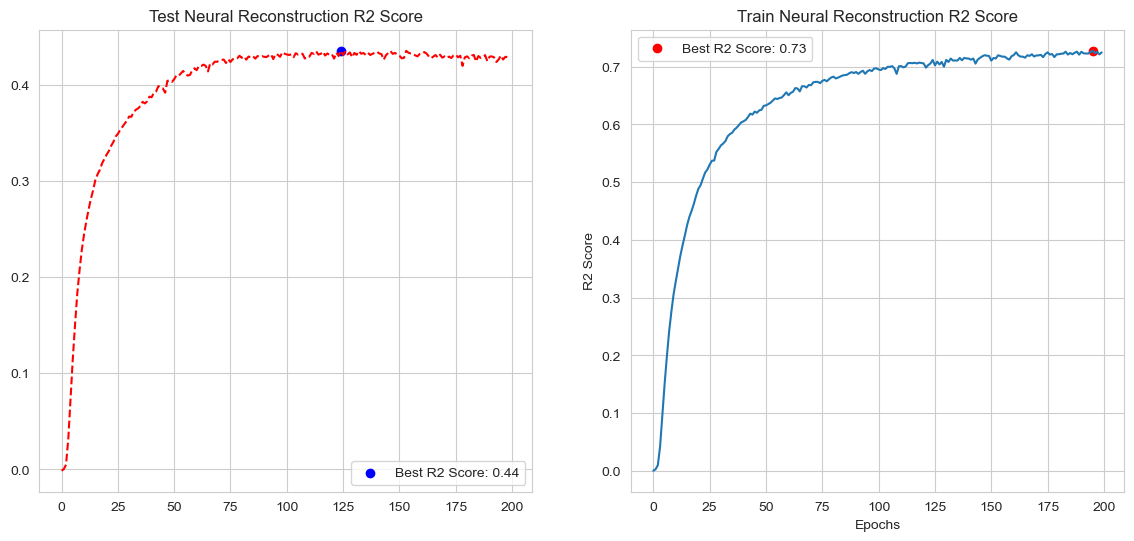

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0].plot(metrics_dict['x_test_r2_scores'], linestyle='dashed', color='red')
axs[1].plot(metrics_dict['x_train_r2_scores'])
axs[0].set_title('Test Neural Reconstruction R2 Score')
axs[1].set_title('Train Neural Reconstruction R2 Score')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
best_x = np.argmax(metrics_dict['x_test_r2_scores'])
best_y = np.max(metrics_dict['x_test_r2_scores'])
best_x_train = np.argmax(metrics_dict['x_train_r2_scores'])
best_y_train = np.max(metrics_dict['x_train_r2_scores'])
axs[0].scatter(best_x, best_y, color='blue', label=f'Best R2 Score: {best_y:.2f}')
axs[0].legend()
axs[1].scatter(best_x_train, best_y_train, color='red', label=f'Best R2 Score: {best_y_train:.2f}')
axs[1].legend()

# plt.savefig('../images/x_r2_128dim_200_epochs_0.05_beta_2_layer.png')
plt.show()

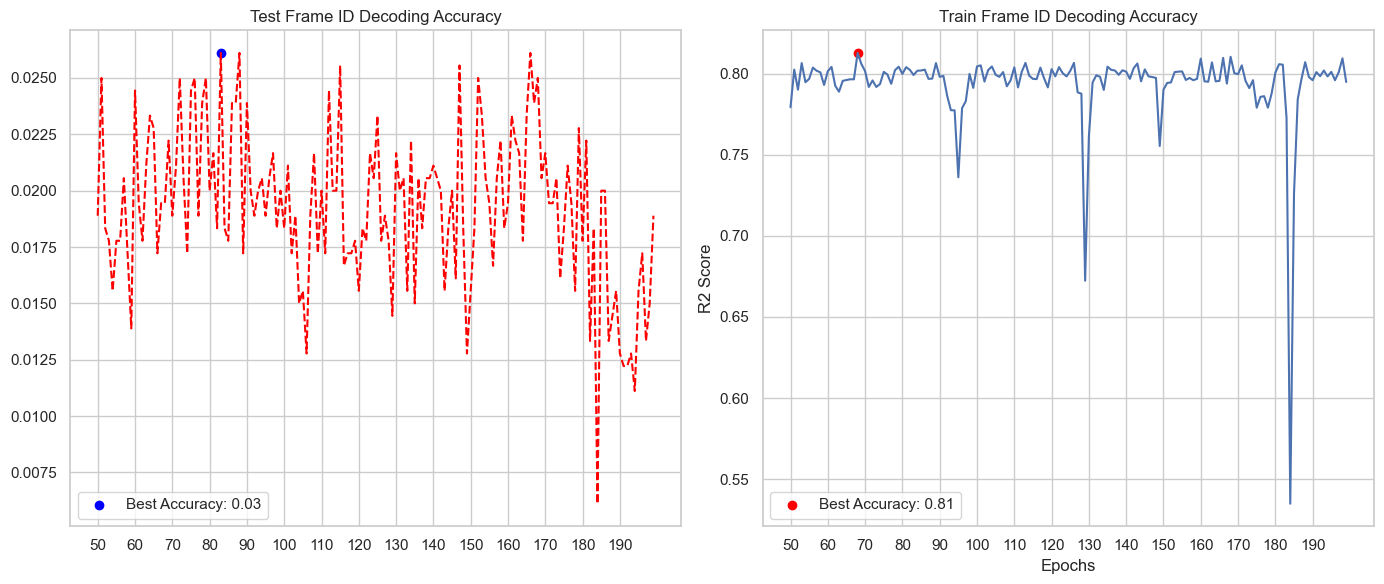

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")
fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0].plot(metrics_dict['y_test_accuracy'][50: ], linestyle='dashed', color='red')
axs[1].plot(metrics_dict['y_train_accuracy'][50: ])
axs[0].set_xticks(range(0, 150, 10))
axs[1].set_xticks(range(0, 150, 10))
axs[1].set_xticklabels(range(50, 200, 10))
axs[0].set_xticklabels(range(50, 200, 10))

axs[0].set_title('Test Frame ID Decoding Accuracy')
axs[1].set_title('Train Frame ID Decoding Accuracy')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
best_x = np.argmax(metrics_dict['y_test_accuracy'][50: ])
best_y = np.max(metrics_dict['y_test_accuracy'][50: ])
best_x_train = np.argmax(metrics_dict['y_train_accuracy'][50: ])
best_y_train = np.max(metrics_dict['y_train_accuracy'][50: ])
axs[0].scatter(best_x, best_y, color='blue', label=f'Best Accuracy: {best_y:.2f}')
axs[0].legend()
axs[1].scatter(best_x_train, best_y_train, color='red', label=f'Best Accuracy: {best_y_train:.2f}')
axs[1].legend()

plt.tight_layout()
# plt.savefig('../images/frame_id_accuracy_128dim_503_top_var_200_epochs_0.05_beta_2_layer_.2_dropout.png')
plt.show()

(.4, .04, 1 decoder layer + Relu At the End + 1e-3 weight decay), (.39, .04, 2 decoder layer + 1e-3 weight decay)

What has been tried for VAE to learn the frame ID using guidance. 
1. Varying the number of layers in the encoder and decoder. Maybe a deeper network can learn a more complex latent that is linearly separable for the frame ID.
2. Varying the number of dimensions in the latent space. Higher dimensions actually performed worse in the test set. 
3. Changing the weight decay or l2 regularization. This helped a little bit but not significantly to see better results than using PCA logistic regression.

In [106]:
X_t, X_val, _, _, y_t, y_val = data_split

In [107]:
with torch.no_grad():
    (_, _, _), _, hidden_preds, _, = vae_model(torch.tensor(X_t, dtype=torch.float32), phase='test')
    (_, _, _), _, hidden_val, _, = vae_model(torch.tensor(X_val, dtype=torch.float32), phase='test')

In [108]:
pca = PCA(n_components = 3)
hidden_val_pca = pca.fit_transform(hidden_val)



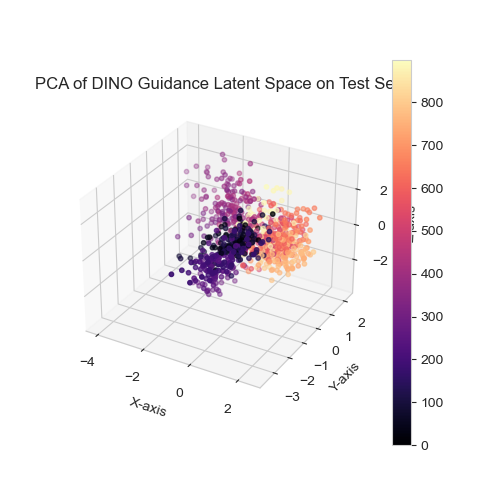

In [110]:
%matplotlib widget

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(hidden_val_pca[:900, 0], hidden_val_pca[:900, 1], hidden_val_pca[:900, 2], c=np.arange(900), cmap='magma', s=10)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.grid(True)
# plt.axis('off')
plt.colorbar(scatter)
plt.title('PCA of DINO Guidance Latent Space on Test Set')
# plt.savefig('../images/pca_of_no_guidance_latents.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
X_t_vae = hidden_preds.numpy()
X_val_vae = hidden_val.numpy()
y_t_vae = y_t
y_val_vae = y_val

In [69]:
logistic_model = LogisticRegression(random_state=2024, max_iter=5000)
logistic_model.fit(X_t_vae, y_t_vae)

y_pred = logistic_model.predict(X_val_vae)

accuracy = accuracy_score(y_val_vae, y_pred)
mae = np.mean(np.abs(y_val_vae - y_pred))

In [70]:
accuracy, mae

(0.03111111111111111, 60.159444444444446)

**Logistic Regression**

2.5% accuracy 58 average frame error Using No Guidance

2.3% accuracy and 39 average frame error Using PCA .9 explained variance guidance of Dino Embeddings

2.3% accuracy and 64 average frame error Using Frame ID Guidance

2.1% accuracy and 115 average frame error Using Frame ID Guidance w Dropout

**KNN**

2.8% accuracy 86 average frame error Using Frame ID Guidance

1.8% accuracy 162 average frame error Using Frame ID Guidance w Dropout

2.05% accuracy 130 average frame error Using No Guidance

1.6% accuracy 90 average frame error Using PCA .9 explained variance guidance of Dino Embeddings

In [66]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_t_vae, y_t_vae)

y_pred = knn.predict(X_val_vae)
accuracy = accuracy_score(y_val_vae, y_pred)
mae = np.mean(np.abs(y_val_vae - y_pred))

In [67]:
accuracy, mae

(0.015, 134.60833333333332)

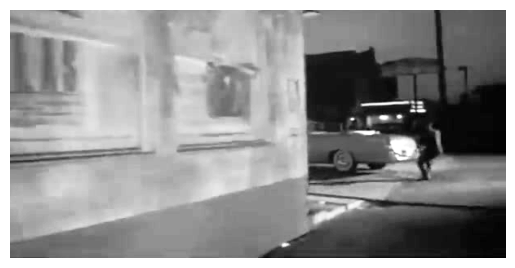

In [ ]:
generate_video_from_np(y_pred, 'vae_hidden_.9_pca_dino_logistic_reg_video') 

### AE Model

In [40]:
import torch
import torch.nn as nn


mse_loss = nn.MSELoss(reduction='mean')
ce_loss = nn.CrossEntropyLoss(reduction='mean')

class AE_Model(nn.Module):
    def __init__(self, x_dim, y_dim, z_dim):
        super(AE_Model, self).__init__()
        # Behavioral Decoder Weights
        self.label_dim_n = y_dim

        self.weight_matrix_WT = None
        if self.label_dim_n > 0:
            self.weight_matrix_WT = nn.Linear(self.label_dim_n, 1, bias=True)

        # Encoder Weights
        self.x_dim = x_dim

        encoder_layers, neural_decoder_layers = [], []
        prev_size = x_dim

        hidden_sizes = [x_dim, z_dim]

        for i, hidden_size in enumerate(hidden_sizes):
            encoder_layers.append(nn.Linear(prev_size, hidden_size))
            encoder_layers.append(nn.LeakyReLU())
            prev_size = hidden_size
        
        decoder_hidden_sizes = [x_dim]
        prev_size = z_dim
        for i, hidden_size in enumerate(decoder_hidden_sizes):
            neural_decoder_layers.append(nn.Linear(prev_size, hidden_size))
            # if i != len(decod) - 1:
            neural_decoder_layers.append(nn.LeakyReLU())
            prev_size = hidden_size

        self.encoder = nn.Sequential(*encoder_layers)
        self.neural_decoder = nn.Sequential(*neural_decoder_layers)

        print(f'Encoder: {self.encoder}')
        print(f'Decoder: {self.neural_decoder}')
        
        # Beta Values

    def decode(self, z):
        x_hat = self.neural_decoder(z)

        y_hat = torch.zeros((z.shape[0], 1))
        if self.label_dim_n > 0:
            y_hat = self.weight_matrix_WT(z)

        return x_hat, y_hat

    def forward(self, x):
        z = self.encoder(x)

        return self.decode(z), z

    # AE Loss Function
    def ae_loss_func(self, x_hat, y_hat, x, y):
        mse_x = mse_loss(x_hat, x)

        mse_y = mse_loss(y_hat, y)

        mse = mse_x 
        if self.label_dim_n > 0:
            mse += mse_y

        return mse, mse_x, mse_y

In [44]:
def validate_AE_model_r2_rmse(model, x, y):
      with torch.no_grad():
        # Get the Hidden States
         (x_preds, y_preds), _, = model(torch.tensor(x, dtype=torch.float32))

         x_preds_flatten = x_preds.reshape(-1, x_preds.shape[-1])

         neural_actual = x
         neural_predicted = x_preds_flatten

         x_mse = torch.mean((neural_predicted - neural_actual) ** 2) 
         x_rmse = torch.sqrt(x_mse)  
         x_r2_score_value = r2_score(np.array(x), np.array(x_preds_flatten))

         y_preds_flatten = y_preds.reshape(-1, y_preds.shape[-1])

         y_actual = y
         y_predicted = y_preds_flatten

         y_mse = torch.mean((y_predicted - y_actual) ** 2) 
         y_rmse = torch.sqrt(y_mse)  
         y_r2_score_value = r2_score(np.array(y_actual), np.array(y_preds_flatten))

         return x_rmse, x_r2_score_value, y_rmse, y_r2_score_value
      
def init_AE_model(X, Y, seed, hidden_size=10, y_dim=5):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

    ae_model = AE_Model(x_dim=X.shape[-1], y_dim=y_dim, z_dim=hidden_size)

    ae_model.apply(weights_init)
    return X_train, X_test, y_train, y_test, ae_model

def AE_model_training_and_validating(X, Y, seed, num_epochs=400, silent=False, concat_train_test=False, hidden_size=10, y_dim = 5):
    
    init_args = (X, Y, seed, hidden_size, y_dim)

    X_train, X_test, y_train, y_test, ae_model = init_AE_model(*init_args)

    optimizer = optim.Adam(ae_model.parameters(), lr=1e-3)

    x_data = np.concatenate((X_train, X_test), axis=0) if concat_train_test else X_train
    y_data = np.concatenate((y_train, y_test), axis=0) if concat_train_test else y_train

    dataset = CustomDataset(x_data, y_data)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    loss_keys = ['losses', 'losses_x', 'losses_y', 'losses_c']
    x_train_metrics = ['x_train_rmses', 'x_train_r2_scores', 'y_train_rmses', 'y_train_r2_scores']
    x_test_metrics = ['x_test_rmses', 'x_test_r2_scores', 'y_test_rmses', 'y_test_r2_scores']
    losses_dict = {k: [] for k in loss_keys}
    metrics_dict = {k: [] for k in x_train_metrics + x_test_metrics}

    for epoch in range(1, num_epochs + 1):
        ae_model.train()  
        total_mse_loss, total_mse_x_loss, total_mse_y_loss = 0, 0, 0

        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()

            (x_hat, y_hat), _ = ae_model(x)

            loss, loss_x, loss_y = ae_model.ae_loss_func(x_hat, y_hat, x, y)

            total_mse_loss += loss.item(); total_mse_x_loss += loss_x.item(); total_mse_y_loss += loss_y.item()

            loss.backward()
            optimizer.step()


        losses_dict['losses'].append(total_mse_loss); losses_dict['losses_x'].append(total_mse_x_loss); losses_dict['losses_y'].append(total_mse_y_loss)

        x_train_rmse, x_train_r2_score, y_train_rmse, y_train_r2_score = validate_AE_model_r2_rmse(ae_model, x_data, y_data) if concat_train_test else validate_AE_model_r2_rmse(ae_model, X_train, y_train)
        x_test_rmse, x_test_r2_score, y_test_rmse, y_test_r2_score = validate_AE_model_r2_rmse(ae_model, X_test, y_test)

        metrics_dict['x_train_rmses'].append(x_train_rmse); metrics_dict['x_train_r2_scores'].append(x_train_r2_score); metrics_dict['y_train_rmses'].append(y_train_rmse); metrics_dict['y_train_r2_scores'].append(y_train_r2_score)
        metrics_dict['x_test_rmses'].append(x_test_rmse); metrics_dict['x_test_r2_scores'].append(x_test_r2_score); metrics_dict['y_test_rmses'].append(y_test_rmse); metrics_dict['y_test_r2_scores'].append(y_test_r2_score)

        if (epoch % 20 == 0 or epoch == 1) and not silent:
            print(f"Epoch number: {epoch} losses_x: {format_loss(losses_dict['losses_x'][-1])}, losses_y: {format_loss(losses_dict['losses_y'][-1])}, total_loss: {format_loss(losses_dict['losses'][-1])}, test_r2: {format_loss(x_test_r2_score)} ")


    return ae_model, losses_dict, metrics_dict

In [ ]:
X_train = np_train_grouped
y_train = np.expand_dims(train_frame_index_grouped, axis=1)

In [45]:
seed = 2024
set_seed(int(seed))
print("model results of seed: ", seed)
args = {
    'X': X_train,
    'Y': y_train,
    'seed': seed,
    'num_epochs': 200,
    'silent': False,
    'concat_train_test': False,
    'hidden_size': 128,
    'y_dim': 0,
}
ae_model, losses_dict, metrics_dict = AE_model_training_and_validating(**args)

model results of seed:  2024
Encoder: Sequential(
  (0): Linear(in_features=772, out_features=772, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=772, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
)
Decoder: Sequential(
  (0): Linear(in_features=128, out_features=772, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
)
Epoch number: 1 losses_x: 54.68, losses_y: 54,417,573.00, total_loss: 54.68, test_r2: -0.02 
Epoch number: 20 losses_x: 26.03, losses_y: 54,508,585.94, total_loss: 26.03, test_r2: 0.17 
Epoch number: 40 losses_x: 20.44, losses_y: 54,471,596.69, total_loss: 20.44, test_r2: 0.23 
Epoch number: 60 losses_x: 17.68, losses_y: 54,485,376.59, total_loss: 17.68, test_r2: 0.23 
Epoch number: 80 losses_x: 16.48, losses_y: 54,512,300.81, total_loss: 16.48, test_r2: 0.25 
Epoch number: 100 losses_x: 15.96, losses_y: 54,444,594.06, total_loss: 15.96, test_r2: 0.19 
Epoch number: 120 losses_x: 15.03, losses_y: 54,432,160.25, total_loss: 

KeyboardInterrupt: 